In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from warnings import filterwarnings
filterwarnings('ignore')

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC, SVR
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from tensorflow.keras.layers import LSTM, Dense

from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error,r2_score

## R-Squared 계산 함수 정의
def show_reg_result(y_test,y_pred):
    print("Max Error: ",
      round(np.abs(y_test - y_pred).max(),3))
    print("Mean Absolute Error: ",
      round(np.abs(y_test-y_pred).mean(),3))
    print("Root Mean Squared Error: ",
      mean_squared_error(y_test,y_pred, squared=False).round(3))
    print("R-Squared: ",
      r2_score(y_test, y_pred).round(3))

## 교차 검증을 수행하는 함수 정의
def cross_validation(model, X, y, n=5):
    cv = KFold(n, shuffle=False)
    return cross_val_score(model, X, y, cv=cv).mean().round(4)

# 입력 변수 가중치
def plot_feature_weight(feature, weight, N=20):
    plt.figure(figsize=(8,int(N/2)))
    W = pd.DataFrame({'feature':feature[:N],'weight':weight[:N]})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

def plot_reg_result(y_test, y_pred, N=50):
    y_test=y_test.ravel()
    y_pred=y_pred.ravel()
    plt.plot(y_test[:N], 'r.-', label='y_test')
    plt.plot(y_pred[:N], 'b.--', label='y_pred')
    plt.legend()
    plt.show()
    plt.title("Residue Plot")
    plt.scatter(y_test, y_test-y_pred, s=5)


#
# 1. Data Load

### 1-1) Data Import

In [ ]:
data = pd.read_excel('CAPE.xlsx')
data.columns

Index(['NO', 'YEAR_MONTH', 'CB_TYPE', 'VSL_TYPE', 'TC_TYPE', 'CB_INDEX',
       'IND_12', 'IND_11', 'IND_10', 'IND_9', 'IND_8', 'IND_7', 'IND_6',
       'IND_5', 'IND_4', 'IND_3', 'IND_2', 'IND_1', 'M_12', 'M_11', 'M_10',
       'M_9', 'M_8', 'M_7', 'M_6', 'M_5', 'M_4', 'M_3', 'M_2', 'M_1',
       'M_AVG_CB3', 'M_AVG_CB6', 'M_AVG_CB12', 'MHIRE_12', 'MHIRE_11',
       'MHIRE_10', 'MHIRE_9', 'MHIRE_8', 'MHIRE_7', 'MHIRE_6', 'MHIRE_5',
       'MHIRE_4', 'MHIRE_3', 'MHIRE_2', 'MHIRE_1', 'MHIRE_AVG_CB3',
       'MHIRE_AVG_CB6', 'MHIRE_AVG_CB12', 'DAY_CB', 'DAY_HIRE'],
      dtype='object')

### 1-2) 컬럼명 변환

In [ ]:
data.columns = ['No', 'Month', 'Line', 'Type', 'Owned',
                'BDI','IND-12', 'IND-11', 'IND-10', 'IND-9', 'IND-8', 'IND-7', 'IND-6', 'IND-5', 'IND-4', 'IND-3', 'IND-2', 'IND-1',
                'M-12', 'M-11', 'M-10', 'M-9', 'M-8', 'M-7', 'M-6', 'M-5', 'M-4', 'M-3', 'M-2', 'M-1',
                'M-AVG3', 'M-AVG6', 'M-AVG12',
                'TC-12', 'TC-11', 'TC-10', 'TC-9', 'TC-8', 'TC-7', 'TC-6', 'TC-5', 'TC-4', 'TC-3', 'TC-2', 'TC-1',
                'TC-AVG3','TC-AVG6','TC-AVG12',
                'DAY_CB', 'DAY_HIRE']
data.shape

(196, 50)

In [ ]:
data[:3]

,No,Month,Line,Type,Owned,BDI,IND-12,IND-11,IND-10,IND-9,...,TC-5,TC-4,TC-3,TC-2,TC-1,TC-AVG3,TC-AVG6,TC-AVG12,DAY_CB,DAY_HIRE
0,101,201501,TR,CAPE,OWNED,627,2171,1674,2766,1887,...,0,0,0,0,0,0,0,0,19858,0
1,109,201502,TR,CAPE,OWNED,612,1674,2766,1887,1508,...,0,0,0,0,0,0,0,0,17825,0
2,117,201503,TR,CAPE,OWNED,439,2766,1887,1508,1768,...,0,0,0,0,0,0,0,0,18370,0


In [ ]:
data.set_index('Month', inplace=True)
data

,No,Line,Type,Owned,BDI,IND-12,IND-11,IND-10,IND-9,IND-8,...,TC-5,TC-4,TC-3,TC-2,TC-1,TC-AVG3,TC-AVG6,TC-AVG12,DAY_CB,DAY_HIRE
Month,,,,,,,,,,,,,,,,,,,,,
201501,101,TR,CAPE,OWNED,627,2171,1674,2766,1887,1508,...,0,0,0,0,0,0,0,0,19858,0
201502,109,TR,CAPE,OWNED,612,1674,2766,1887,1508,1768,...,0,0,0,0,0,0,0,0,17825,0
201503,117,TR,CAPE,OWNED,439,2766,1887,1508,1768,1451,...,0,0,0,0,0,0,0,0,18370,0
201504,125,TR,CAPE,OWNED,508,1887,1508,1768,1451,1854,...,0,0,0,0,0,0,0,0,19303,0
201505,133,TR,CAPE,OWNED,782,1508,1768,1451,1854,2306,...,0,0,0,0,0,0,0,0,19964,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202304,894,TR,CAPE,TC,1921,1690,3514,2518,2432,1126,...,18456,16761,14898,12444,12680,13341,15941,20407,14538,14498
202305,902,TR,CAPE,TC,2143,3514,2518,2432,1126,1421,...,16761,14898,12444,12680,14498,13207,14956,19462,14683,14724
202306,910,TR,CAPE,TC,1597,2518,2432,1126,1421,2117,...,14898,12444,12680,14498,14724,13967,14334,18590,14281,13866


#
# 2. 불필요 컬럼 삭제
- 공통 : No, Month, Line, Type, Owned
- 사선 : Day_Hire

### 2-1) 공통 불필요 항목 삭제

In [ ]:
data = data.drop(columns=['No', 'Line', 'Type'], axis=1)
data[:3]

,Owned,BDI,IND-12,IND-11,IND-10,IND-9,IND-8,IND-7,IND-6,IND-5,...,TC-5,TC-4,TC-3,TC-2,TC-1,TC-AVG3,TC-AVG6,TC-AVG12,DAY_CB,DAY_HIRE
Month,,,,,,,,,,,,,,,,,,,,,
201501,OWNED,627,2171,1674,2766,1887,1508,1768,1451,1854,...,0,0,0,0,0,0,0,0,19858,0
201502,OWNED,612,1674,2766,1887,1508,1768,1451,1854,2306,...,0,0,0,0,0,0,0,0,17825,0
201503,OWNED,439,2766,1887,1508,1768,1451,1854,2306,2085,...,0,0,0,0,0,0,0,0,18370,0


### 2-2) 사선/용선 데이터 모델 분리

In [ ]:
data_owned = data[data.Owned == 'OWNED'].drop(columns=['Owned', 'TC-12', 'TC-11', 'TC-10', 'TC-9', 'TC-8', 'TC-7', 'TC-6', 'TC-5', 'TC-4',
                                                       'TC-3', 'TC-2', 'TC-1', 'TC-AVG3','TC-AVG6','TC-AVG12', 'DAY_HIRE'], axis=1)
data_tc    = data[data.Owned == 'TC'].drop(columns=['Owned'], axis=1)

data_owned.shape, data_tc.shape

((104, 29), (92, 45))

#
# 3. 모델 테스트 (사선)

In [ ]:
df_owned = data_owned.copy()

### * 훈련 데이터/테스트 데이터를 통한 시각화 Function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def eval_on_features(features, target, n_train, model):

    X = df_owned.index.astype("int64").values.reshape(-1, 1)
    xticks = pd.date_range(start=df_owned.index.min(), end=df_owned.index.max(), freq='M')
    #print(xticks)

    # 년도와 월을 추출하여 xticks_name을 생성합니다.
    xticks_name = [date.strftime("%Y-%m") for date in xticks]
    #month = ["Jan", "Feb", "Mar","Apr", "May", "Jun", "Jul", "Aug", 'Oct', 'Sep', 'Nov', 'Dec']
    #xticks_name = [month[int(m)]+d for m, d in zip(xticks.strftime("%m"),xticks.strftime(" %m-%d"))]
    #plt.xticks(xticks, xticks_name, rotation=90, ha='left')
    #print(xticks_name)

    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    #X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=n_train, shuffle=False)

    model.fit(X_train, y_train)
    print('Train : {:.2f}'.format(model.score(X_train, y_train)))
    print('Test : {:.2f}'.format(model.score(X_test, y_test)))

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure(figsize=(12, 5))

    #plt.xticks(range(0, len(xticks_name), 8), xticks_name, rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="Train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="Test")
    plt.plot(range(n_train), y_pred_train, '--', label="Train Pred")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="Test Pred")

    plt.legend(loc='best')
    plt.title(model)
    plt.xlabel("Date")
    plt.ylabel("Daily C/B")

    return y_train, y_test, y_pred

In [ ]:
X_owned = df_owned.drop('DAY_CB', axis=1)
y_owned = df_owned.DAY_CB

n_train = int(len(X_owned)*0.75)

X_owned.shape, y_owned.shape

((104, 28), (104,))

### (Test) R-Squared 저하로 인해 이동 평균 항목 삭제

In [ ]:
# X_owned = X_owned.drop(columns=['M-AVG3', 'M-AVG6', 'M-AVG12'], axis=1)
# X_owned.info()

### 3-1) LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

# y_train, y_test, y_pred = eval_on_features(X_owned, y_owned, n_train, LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9385567997193994, 0.8432201087450408)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  2398.894
Mean Absolute Error:  822.369
Root Mean Squared Error:  1086.122
R-Squared:  0.843


### 3-2) LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(random_state=51)
# y_train, y_test, y_pred = eval_on_features(X_owned, y_owned, n_train, lgbm)

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned, random_state=52)

lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

lgbm.score(X_train, y_train), lgbm.score(X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000097 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 766
[LightGBM] [Info] Number of data points in the train set: 78, number of used features: 28
[LightGBM] [Info] Start training from score 21577.589744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

(0.9283967830157059, 0.5836586386164302)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  3612.571
Mean Absolute Error:  1432.398
Root Mean Squared Error:  1753.225
R-Squared:  0.584


### 3-3) RandomForest

In [ ]:
rf = RandomForestRegressor(n_estimators=10, random_state=53)
# y_train, y_test, y_pred = eval_on_features(X_owned, y_owned, n_train, rf)

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned,  random_state=54)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.9728528521451416, 0.5643484347917285)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  3414.3
Mean Absolute Error:  1075.731
Root Mean Squared Error:  1415.468
R-Squared:  0.564


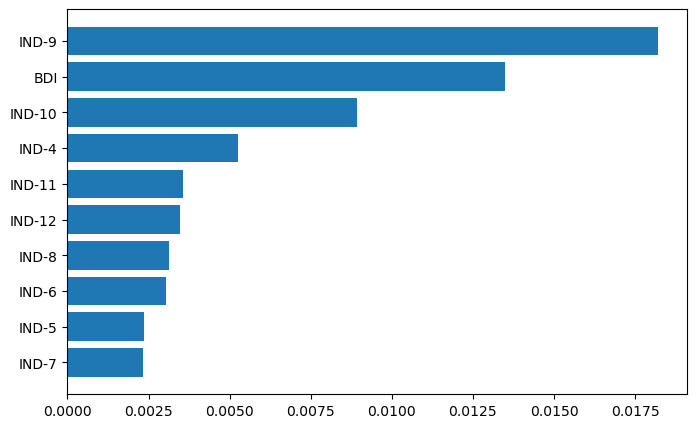

In [ ]:
plot_feature_weight(X_owned.columns, rf.feature_importances_, N=10)

### 3-4) SVM

In [ ]:
from sklearn.svm import LinearSVC

svm = SVC(gamma=10, C=0.001)
# y_train, y_test, y_pred = eval_on_features(X_owned, y_owned, n_train, rf)

X_train, X_test, y_train, y_test = train_test_split(X_owned, y_owned,  random_state=61)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

svm.score(X_train, y_train), svm.score(X_test, y_test)

(1.0, 0.0)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  11974
Mean Absolute Error:  8923.038
Root Mean Squared Error:  9162.596
R-Squared:  -18.377


#
# 4. 모델 테스트 (용선)

In [ ]:
df_tc = data_tc.copy()

### * 훈련 데이터/테스트 데이터를 통한 시각화 Function

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def eval_on_features(features, target, n_train, model):

    X = df_tc.index.astype("int64").values.reshape(-1, 1)
    xticks = pd.date_range(start=df_tc.index.min(), end=df_tc.index.max(), freq='M')
    #print(xticks)

    # 년도와 월을 추출하여 xticks_name을 생성합니다.
    xticks_name = [date.strftime("%Y-%m") for date in xticks]
    #month = ["Jan", "Feb", "Mar","Apr", "May", "Jun", "Jul", "Aug", 'Oct', 'Sep', 'Nov', 'Dec']
    #xticks_name = [month[int(m)]+d for m, d in zip(xticks.strftime("%m"),xticks.strftime(" %m-%d"))]
    #plt.xticks(xticks, xticks_name, rotation=90, ha='left')
    #print(xticks_name)

    X_train, X_test = features[:n_train], features[n_train:]
    y_train, y_test = target[:n_train], target[n_train:]
    #X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=n_train, shuffle=False)

    model.fit(X_train, y_train)
    print('Train : {:.2f}'.format(model.score(X_train, y_train)))
    print('Test : {:.2f}'.format(model.score(X_test, y_test)))

    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    plt.figure(figsize=(12, 5))

    #plt.xticks(range(0, len(xticks_name), 8), xticks_name, rotation=90, ha="left")

    plt.plot(range(n_train), y_train, label="Train")
    plt.plot(range(n_train, len(y_test) + n_train), y_test, '-', label="Test")
    plt.plot(range(n_train), y_pred_train, '--', label="Train Pred")
    plt.plot(range(n_train, len(y_test) + n_train), y_pred, '--', label="Test Pred")

    plt.legend(loc='best')
    plt.title(model)
    plt.xlabel("Date")
    plt.ylabel("Daily C/B")

    return y_train, y_test, y_pred

In [ ]:
X_tc = df_tc.drop('DAY_CB', axis=1)
y_tc = df_tc.DAY_CB

n_train = int(len(X_tc)*0.75)

X_tc.shape, y_tc.shape

((92, 44), (92,))

### 4-1) LinearRegression

In [ ]:
from sklearn.linear_model import LinearRegression

#y_train, y_test, y_pred = eval_on_features(X_owned, y_owned, n_train, LinearRegression())

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc, random_state=1)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.9985684748526757, 0.965360689844389)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  2238.191
Mean Absolute Error:  967.219
Root Mean Squared Error:  1116.792
R-Squared:  0.965


### 4-2) LGBMRegressor

In [ ]:
lgbm = LGBMRegressor(random_state=51)
# y_train, y_test, y_pred = eval_on_features(X_owned, y_owned, n_train, lgbm)

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc, random_state=52)

lgbm.fit(X_train, y_train)

y_pred = lgbm.predict(X_test)

lgbm.score(X_train, y_train), lgbm.score(X_test, y_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1065
[LightGBM] [Info] Number of data points in the train set: 69, number of used features: 44
[LightGBM] [Info] Start training from score 13549.028986
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain

(0.9485963337310512, 0.8595308420074124)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  7082.433
Mean Absolute Error:  2454.027
Root Mean Squared Error:  3072.417
R-Squared:  0.86


### 4-3) RandomForest

In [ ]:
rf = RandomForestRegressor(n_estimators=10, random_state=53)
# y_train, y_test, y_pred = eval_on_features(X_owned, y_owned, n_train, rf)

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc,  random_state=54)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

rf.score(X_train, y_train), rf.score(X_test, y_test)

(0.9890700841426956, 0.800493271796804)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  9327.2
Mean Absolute Error:  2129.448
Root Mean Squared Error:  3348.818
R-Squared:  0.8


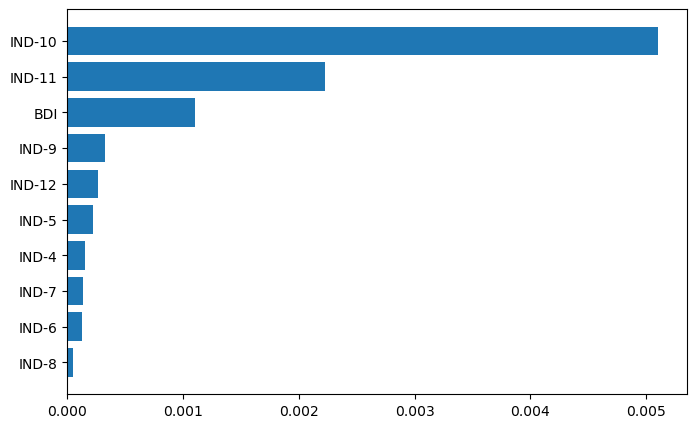

In [ ]:
plot_feature_weight(X_tc.columns, rf.feature_importances_, N=10)

### 4-4) SVM

In [ ]:
from sklearn.svm import LinearSVC

svm = SVC(gamma=10, C=0.001)
# y_train, y_test, y_pred = eval_on_features(X_owned, y_owned, n_train, rf)

X_train, X_test, y_train, y_test = train_test_split(X_tc, y_tc,  random_state=61)

svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

svm.score(X_train, y_train), svm.score(X_test, y_test)

(0.028985507246376812, 0.0)

In [ ]:
show_reg_result(y_test,y_pred)

Max Error:  22486
Mean Absolute Error:  5713.174
Root Mean Squared Error:  7813.509
R-Squared:  -0.892
